# Visualisation of data

First we are interested in showing the process of data filtering. How much data do we begin with and how does this number change as we begin filtering? 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

entry_counter = []

data = pd.read_csv('../Data/All_Journeys.csv')
entry_counter.append(data['Id'].count())


#Copenhagen filtering
first_cph_filter = (
    (data['internalValidZones'].str.match(r'^(1001|1002|1003|1004)(,(1001|1002|1003|1004))*$')
    | # or
    pd.isna(data['internalValidZones']))
    )

second_cph_filter = (
    (data['internalStartZones'].str.match(r'^(1001|1002|1003|1004)$'))
    | # or
    pd.isna(data['internalStartZones'])
    )

data = data[(first_cph_filter)]
entry_counter.append(data['Id'].count())

data = data[(second_cph_filter)]
entry_counter.append(data['Id'].count())

data = data[ ~ (data['SearchStart'].str.contains("okation", na=False)
                                             | #Or
                                             data['SearchStart'].str.contains("zoner", na=False))]
entry_counter.append(data['Id'].count())


data = data[( ~ (data['SearchEnd'].str.contains("zoner", na=False) 
                                            | #Or
                                            data['SearchEnd'].str.contains("okation", na=False)))]
entry_counter.append(data['Id'].count())

# next two filters are English filters of the first
data = data[( ~ (data['SearchEnd'].str.contains("zones", na=False) 
                                            | #Or
                                            data['SearchEnd'].str.contains("ocation", na=False)))]
entry_counter.append(data['Id'].count())

data = data[( ~ (data['SearchStart'].str.contains("zones", na=False) 
                                            | #Or
                                            data['SearchStart'].str.contains("ocation", na=False)))]
entry_counter.append(data['Id'].count())

# Next filter is to remove entries where one of the matching search-x or x-stop are Null
data = data[(
                                        ( ~ (pd.isna(data['SearchStart'])) & ~ (pd.isna(data['SearchEnd'])))
                                        | # Or
                                        ( ~ (pd.isna(data['StartStop'])) & ~ (pd.isna(data['EndStop'])))
                                        )]
entry_counter.append(data['Id'].count())

# Next filter removes all entries where SearchStart and SearchEnd contain the same value
data = data[(
                        ~(data['SearchStart'] == data['SearchEnd'])
                        )]
entry_counter.append(data['Id'].count())

entry_counter



/var/folders/6c/gl4j6k8x3tn79jcjxtk_ly1h0000gn/T/ipykernel_82905/3445066881.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[(second_cph_filter)]


[43345946,
 16235181,
 12642452,
 8775239,
 8775193,
 8775107,
 8482476,
 3523992,
 3471327]

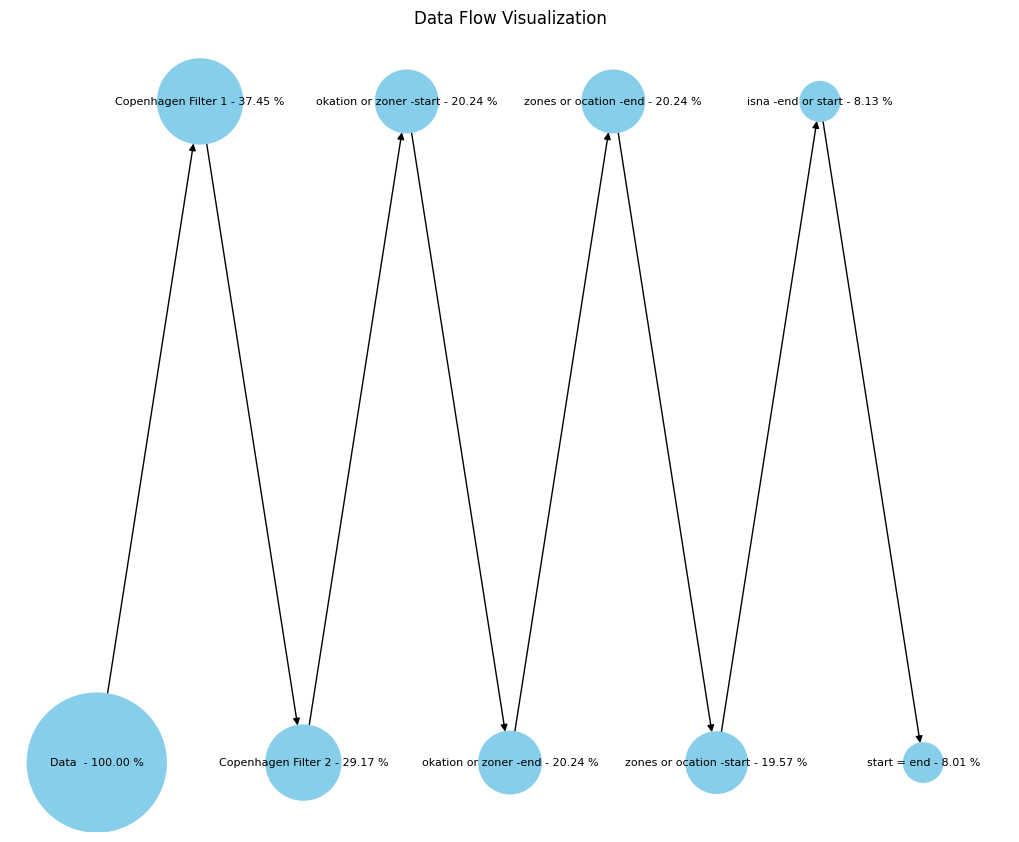

In [89]:
import networkx as nx

# Sample data
normalized_data = [value / entry_counter[0] * 10000 for value in entry_counter]
node_sizes = normalized_data

# Create a graph object
G = nx.DiGraph()

# Add nodes with labels
nodes = ['Data ','Copenhagen Filter 1', 'Copenhagen Filter 2', 'okation or zoner -start', 'okation or zoner -end', 'zones or ocation -end', 'zones or ocation -start', 'isna -end or start',  'start = end']
for node in nodes:
    percent = "{:.2f}".format(normalized_data[nodes.index(node)] / 100)
    nodes[nodes.index(node)] = node + f" - {percent} %"
G.add_nodes_from(nodes)

# Add edges between nodes
nx.add_path(G, nodes)

# Set node positions (optional)
#pos = {node: (i, 50 - i * 10) for i, node in enumerate(nodes)}
# Manually define zigzag positions for nodes
pos = { nodes[0]: (0, 0),
        nodes[1]: (1, 1),
        nodes[2]: (2, 0),
        nodes[3]: (3, 1),
        nodes[4]: (4, 0),
        nodes[5]: (5, 1),
        nodes[6]: (6, 0),
        nodes[7]: (7, 1),
        nodes[8]: (8, 0)}


plt.figure(figsize=(10, 8))  # Adjust the width and height as needed

# Draw the graph
nx.draw(G, 
        pos, 
        with_labels=True, 
        node_size=node_sizes, 
        node_color='skyblue', 
        font_size=8, 
        font_weight='light')

plt.title('Data Flow Visualization')
plt.show()


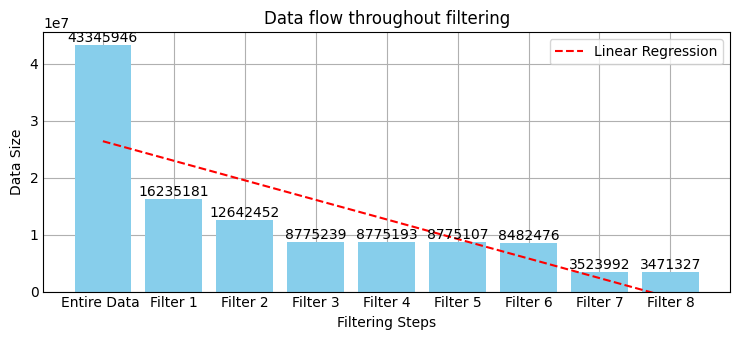

In [94]:
data = [43345946, 16235181, 12642452, 8775239, 8775193, 8775107, 8482476, 3523992, 3471327]
labels = ['Entire Data ','Filter 1', 'Filter 2', 'Filter 3', 'Filter 4', 'Filter 5', 'Filter 6', 'Filter 7',  'Filter 8']

x = np.arange(len(data))
m, b = np.polyfit(x, data, 1)
regression_line = m * x + b

# Create figure and axis
fig, ax = plt.subplots()

# Plot vertical bars
ax.bar(labels, data, color='skyblue')

bars = ax.bar(labels, data, color='skyblue')
for bar, value in zip(bars, data):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(value), ha='center', va='bottom')
    
# Set labels and title
ax.set_xlabel('Filtering Steps')
ax.set_ylabel('Data Size')
ax.set_ylim(bottom=0)
ax.set_title('Data flow throughout filtering')
ax.plot(x, regression_line, color='red', linestyle='--', label='Linear Regression')

ax.legend()

# Show plot
plt.show()

# Visualisation of the distribution of stations

Here we will attempt at creating a graph visualising the distribution of stations. The graph serves the purpose of highlighting the density in our data - is half of the stations in the dataset only part of < 10 journeys? Is there a relatively evenly distribution of stations? 

In [3]:
seq = pd.read_csv('sequences.csv')

station_counter = {}


def get_sequence(row) -> None:
    start   = row[0]
    end     = row[1]
    if start not in station_counter:
        station_counter[start] = 1
    else:
        station_counter[start] = station_counter[start] + 1
    
    if end not in station_counter:
        station_counter[end] = 1
    else:
        station_counter[end] = station_counter[end] + 1
    
seq.apply(get_sequence, axis=1)

/var/folders/6c/gl4j6k8x3tn79jcjxtk_ly1h0000gn/T/ipykernel_8118/164979923.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  start   = row[0]
/var/folders/6c/gl4j6k8x3tn79jcjxtk_ly1h0000gn/T/ipykernel_8118/164979923.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end     = row[1]


0          None
1          None
2          None
3          None
4          None
           ... 
3469301    None
3469302    None
3469303    None
3469304    None
3469305    None
Length: 3469306, dtype: object

In [98]:
res = dict(sorted(station_counter.items(), key = lambda x: x[1], reverse = True)[:10])
res



In [10]:
value_list = []
for value in station_counter.values():
    value_list.append(value)

value_list.sort(reverse=True)
value_list


[561104,
 360454,
 342289,
 326808,
 189228,
 139841,
 115016,
 106272,
 101808,
 88464,
 83667,
 80697,
 79750,
 79508,
 78542,
 77945,
 75800,
 72321,
 71657,
 71547,
 69195,
 69184,
 68363,
 67523,
 66577,
 66499,
 63028,
 62246,
 62202,
 56592,
 51378,
 49705,
 47822,
 43807,
 43288,
 42669,
 42351,
 41246,
 40895,
 40821,
 39270,
 37869,
 37354,
 36758,
 36008,
 35286,
 32875,
 31442,
 31335,
 30693,
 30000,
 29074,
 28145,
 27642,
 26777,
 26374,
 24002,
 23541,
 23118,
 22798,
 22313,
 21742,
 21569,
 21084,
 20923,
 20295,
 20002,
 19324,
 18727,
 18725,
 18689,
 18683,
 18431,
 18193,
 17669,
 17370,
 17309,
 16767,
 16649,
 16314,
 15995,
 15771,
 15570,
 15165,
 14962,
 14876,
 14827,
 14820,
 14217,
 14103,
 13930,
 13445,
 13261,
 13230,
 12898,
 12631,
 12603,
 12527,
 11790,
 11659,
 11513,
 11325,
 11296,
 11175,
 11107,
 10363,
 10248,
 9632,
 9295,
 9084,
 8370,
 8340,
 8228,
 8224,
 8211,
 8181,
 8138,
 8073,
 8055,
 7964,
 7945,
 7934,
 7878,
 7737,
 7687,
 7651,
 7

In [14]:
from collections import Counter

# Extract the values from the dictionary
values = list(station_counter.values())

# Count the occurrences of each integer value
value_counts = Counter(values)
d = dict(value_counts)


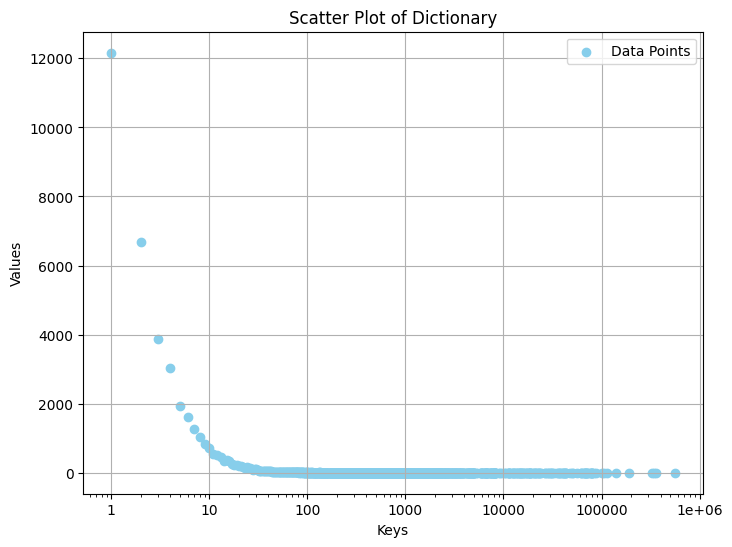

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# Extract keys and values from the dictionary
keys = list(d.keys())
values = list(d.values())

# Create figure and axis
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.scatter(keys, values, color='skyblue', label='Data Points')

# Set labels and title
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Scatter Plot of Dictionary')
plt.xscale('log')

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))

# Add grid
plt.grid(True)

# Show plot
plt.legend()
plt.show()

